
# Project: Investigating TMDB Movies

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> I chose to explore the TMDB dataset.  This dataset contains information on over 10,000 movies including director, cast, voter average, genre, budget and revenue (and more).  I'm curious to find out what features are correlated with a high voter rating?  Specifically, I'm curious if movies with popular cast members have higher movie ratings, do certain genres tend to have higher ratings.  Also, does run time have an impact on rating?  Lastly, I'd like to see the impact of the budget on the rating and revenue generated.


In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [2]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.

df = pd.read_csv('Datasets/tmdb-movies.csv')

df.head(2)


,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08


# Next I want to see an overview of the dataset - datatypes, columns and what columns are missing values

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

# Next I want to see some basic stats - mean, std and percentiles for columns that are numbers

In [4]:
df.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,66064.177434,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,92130.136561,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.250000,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20669.000000,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75610.000000,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


# Check for duplicates

In [5]:
sum(df.duplicated())


1

# Remove the duplicate row

In [6]:
df.drop_duplicates(inplace=True)
sum(df.duplicated())


0

# Split apart cast, genres and production companies to have one value per row.  First create a function called splitter.  Note, that "|" is a regex character, thus won't be detected by the str methods unless encapsulated by brackets or a slash.  This was learned the hard way...

In [7]:
def Splitter(df, column, number, character):
    
    #Not all casts contain 3 or more members.  Thus filter out casts to split by checking the count of "|"
    df_rows_to_split = df[df[column].str.count("[" + character + "]") > (number - 1)]
    df_rows_to_split[column] = df_rows_to_split[column].apply(lambda x: x.split(character)[number])
    
    df = df.append(df_rows_to_split)
    df = df.reset_index()
    del df['index']
    return df

# Now use the function to iterate through the columns that need splitting.  Limit to a max of 3 fields, but also check for fields that contain just one split "|" as well to make sure all actors are accounted for (this is done with the second for statement)

In [11]:
df_updated = df.copy()
columns = ['cast', 'production_companies', 'genres']
for column in columns:
    for i in (0, 1, 2):
        df_updated = Splitter(df_updated, column, i, "|")

c:\users\mateusz.rakowski\appdata\local\continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# Spot check some of the last lines to see the appended rows are indeed split apart without line separators

In [12]:
df_updated[columns].tail(15)

,cast,production_companies,genres
402342,Telly Savalas,Danjaq,Thriller
402343,Katharine Ross,Newman-Foreman Productions,Western
402344,Jean Seberg,Alan Jay Lerner Productions,Comedy
402345,Glenn Gilger,Bill Melendez Productions,Family
402346,Christopher Reeve,Film Export A.G.,Action
402347,Herbert Lom,Pimlico Films,Thriller
402348,Anthony Daniels,Winters Hollywood Entertainment Holdings Corpo...,Family
402349,Burgess Meredith,Shelburne Associates,Thriller
402350,Bruce Dern,Jayne Productions Inc,War
402351,Mike McEwen,Dugong Films,Mystery


# Remove cells that contain the splitter/separator "|"

In [13]:
print("Before: " + str(len(df_updated)))
for column in columns:
    df_updated.drop(df_updated[df_updated[column].str.count("[|]") > 0].index, inplace=True)

print("After:  " + str(len(df_updated)))

Before: 402357
After:  180866


# Check for duplications after appending new rows

In [14]:
sum(df_updated.duplicated())

37898

# Drop the duplicates

In [17]:
df_updated.drop_duplicates(inplace=True)
print(sum(df_updated.duplicated()))
print(len(df_updated))

0
142968


### Note, over half the movies in the database don't have budget or revenue values (see below).  I don't plan to fill these values with a mean or median as it's a very large amount of data and making such an assumption for so many values can lead to misleading analysis.  Instead, when I will look at budget and revenue numbers later, I'll omit the null rows.  When I'm looking at non budget and revenue numbers, then I'll use all rows to maximize the data used.

In [18]:
print(len(df[df['budget']==0])/len(df))
print(len(df[df['budget_adj']==0])/len(df))
print(len(df[df['revenue']==0])/len(df))
print(len(df[df['revenue_adj']==0])/len(df))

print(df[df['budget']>0][['budget_adj', 'budget', 'revenue', 'revenue_adj']].describe())
df[df['revenue']>0][['budget_adj', 'budget', 'revenue', 'revenue_adj']].describe()

0.5242521859180856
0.5242521859180856
0.5537045559134837
0.5537045559134837
         budget_adj        budget       revenue   revenue_adj
count  5.169000e+03  5.169000e+03  5.169000e+03  5.169000e+03
mean   3.688907e+07  3.073958e+07  8.029101e+07  1.021953e+08
std    4.196096e+07  3.890441e+07  1.594865e+08  1.959194e+08
min    9.210911e-01  1.000000e+00  0.000000e+00  0.000000e+00
25%    8.102293e+06  6.000000e+06  0.000000e+00  0.000000e+00
50%    2.271505e+07  1.700000e+07  2.100156e+07  2.863167e+07
75%    5.008384e+07  4.000000e+07  8.945676e+07  1.134196e+08
max    4.250000e+08  4.250000e+08  2.781506e+09  2.827124e+09


,budget_adj,budget,revenue,revenue_adj
count,4.849000e+03,4.849000e+03,4.849000e+03,4.849000e+03
mean,3.516208e+07,2.956961e+07,8.923886e+07,1.151009e+08
std,4.376117e+07,4.051761e+07,1.620801e+08,1.988557e+08
min,0.000000e+00,0.000000e+00,2.000000e+00,2.370705e+00
25%,2.329409e+06,1.700000e+06,7.732325e+06,1.046585e+07
50%,2.032801e+07,1.500000e+07,3.185308e+07,4.395666e+07
75%,4.973516e+07,4.000000e+07,9.996575e+07,1.316482e+08
max,4.250000e+08,4.250000e+08,2.781506e+09,2.827124e+09


# Create bins for the vote average, runtime, budget, budget_adj, revenue and revenue_adj.  Also, since half the data is missing money related data, create money bins based on the percentiles from the data that does have money values (since when I plan to analyze money specific data, then I'll omit the null rows).  Lastly, for rows that do have revenue, create a column to see if the movie made money, ie, revenue was greater than the budget

In [19]:
# Vote Average Rating
bin_edges = [1.5, 5.4, 6, 6.6, 9.2]
bin_names = ['Poor', 'Average', 'Good', 'Excellent']
df_updated['Rating'] = pd.cut(df_updated['vote_average'], bin_edges, labels=bin_names)

# Movie Length Grouping
bin_edges = [0, 90, 99, 111, 900]
bin_names = ['Short', 'Average', 'Long', 'Very_Long']
df_updated['Movie_Length'] = pd.cut(df_updated['runtime'], bin_edges, labels=bin_names)

# Budget Adj Grouping
bin_edges = [0, 1, 8.102293e+06, 2.271505e+07, 5.008384e+07, 4.250000e+08]
bin_names = ['Missing', 'Cheap', 'Average', 'Expensive', 'Crazy_Expensive']
df_updated['budget_adj_bucket'] = pd.cut(df_updated['budget_adj'], bin_edges, labels=bin_names)

# Budget Grouping
bin_edges = [0, 1.01, 6.000000e+06, 1.700000e+07, 4.000000e+07, 4.250000e+08]
bin_names = ['Missing', 'Cheap', 'Average', 'Expensive', 'Crazy_Expensive']
df_updated['budget_bucket'] = pd.cut(df_updated['budget'], bin_edges, labels=bin_names)

# Revenue Adj Grouping
bin_edges = [0, 2.370705, 1.046585e+07, 4.395666e+07, 1.316482e+08, 2.827124e+09]
bin_names = ['Missing', 'Poor', 'Average', 'Good', 'Great']
df_updated['revenue_adj_bucket'] = pd.cut(df_updated['revenue_adj'], bin_edges, labels=bin_names)

# Revenue Grouping
bin_edges = [0, 2, 7.732325e+06, 3.185308e+07, 9.996575e+07, 2.781506e+09]
bin_names = ['Missing', 'Poor', 'Average', 'Good', 'Great']
df_updated['revenue_adj_bucket'] = pd.cut(df_updated['revenue_adj'], bin_edges, labels=bin_names)

# Made Money
df_updated['Rev_Performance'] = "Unknown"
df_updated[(df_updated['revenue']>0) & (df_updated['budget']>df_updated['revenue'])]['Rev_Performance'] = "Negative"
df_updated[(df_updated['revenue']>0) & (df_updated['budget']==df_updated['revenue'])]['Rev_Performance'] = "Neutral"
df_updated[(df_updated['revenue']>0) & (df_updated['budget']<df_updated['revenue'])]['Rev_Performance'] = "Positive"

df_updated.head()

c:\users\mateusz.rakowski\appdata\local\continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\mateusz.rakowski\appdata\local\continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\mateusz.rakowski\appdata\local\continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,vote_average,release_year,budget_adj,revenue_adj,Rating,Movie_Length,budget_adj_bucket,budget_bucket,revenue_adj_bucket,Rev_Performance
371,345637,tt4661600,0.422901,0,0,Sanjay's Super Team,NaN,NaN,Sanjay Patel,NaN,...,6.9,2015,0.0,0.0,Excellent,Short,NaN,NaN,NaN,Unknown
465,321109,tt4393514,0.201696,0,0,Bitter Lake,NaN,NaN,Adam Curtis,NaN,...,7.8,2015,0.0,0.0,Excellent,Very_Long,NaN,NaN,NaN,Unknown
494,361671,tt5227516,0.129455,0,0,Ellis,Robert De Niro,http://jr-art.net,JR,NaN,...,7.2,2015,0.0,0.0,Excellent,Short,NaN,NaN,NaN,Unknown
500,355178,tt4909348,0.157172,0,0,Amy Schumer: Live at the Apollo,Amy Schumer,http://www.hbo.com/comedy/amy-schumer-live-fro...,Chris Rock,She's a lady,...,7.5,2015,0.0,0.0,Excellent,Short,NaN,NaN,NaN,Unknown
532,320996,tt4073952,0.126594,0,0,Iliza Shlesinger: Freezing Hot,Iliza Shlesinger,http://www.iliza.com/freezing-hot.html,NaN,NaN,...,6.6,2015,0.0,0.0,Good,Short,NaN,NaN,NaN,Unknown


# Create a new column that notates the number of times that an actor has appeared in the movies in this database.  I'll use this as an indicator of how popular an actor is.  To do this, first I'll create a separate dataframe called Actors that simply has the actor name, and the number of times the actor appears in the database.

In [20]:
Actors=df_updated.groupby('cast').filter(lambda x: x['cast'].count()>0)[['cast']].groupby('cast')[['cast']].agg('count').sort_values(by='cast', ascending=False)
type(Actors)

pandas.core.frame.DataFrame

In [21]:
Actors.head()

,cast
cast,
Nicolas Cage,370
Bruce Willis,353
Robert De Niro,348
Samuel L. Jackson,291
Johnny Depp,280


### Now iterate through each actor in the Actors dataframe (which is aggregated by actor, so each actor name shows up only once, thus it's faster to iterate through.  Note, this will still take ~3-10 min to run) and everytime df_updated['cast']==actor, update the new "Actor_Occurrences" column to be equal to the occurrences calculated in the Actors dataframe.  Thus the end result will be the number of times the cast member listed in each row has been seen.

In [22]:
df_updated['Actor_Occurrences'] = 0
df_updated.reset_index(inplace=True)
del df_updated['index']

for actor in Actors.index:
    df_updated.loc[df_updated['cast']==actor, 'Actor_Occurrences']=Actors['cast'][actor]
    
df_updated.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,release_year,budget_adj,revenue_adj,Rating,Movie_Length,budget_adj_bucket,budget_bucket,revenue_adj_bucket,Rev_Performance,Actor_Occurrences
0,345637,tt4661600,0.422901,0,0,Sanjay's Super Team,NaN,NaN,Sanjay Patel,NaN,...,2015,0.0,0.0,Excellent,Short,NaN,NaN,NaN,Unknown,0
1,321109,tt4393514,0.201696,0,0,Bitter Lake,NaN,NaN,Adam Curtis,NaN,...,2015,0.0,0.0,Excellent,Very_Long,NaN,NaN,NaN,Unknown,0
2,361671,tt5227516,0.129455,0,0,Ellis,Robert De Niro,http://jr-art.net,JR,NaN,...,2015,0.0,0.0,Excellent,Short,NaN,NaN,NaN,Unknown,348
3,355178,tt4909348,0.157172,0,0,Amy Schumer: Live at the Apollo,Amy Schumer,http://www.hbo.com/comedy/amy-schumer-live-fro...,Chris Rock,She's a lady,...,2015,0.0,0.0,Excellent,Short,NaN,NaN,NaN,Unknown,5
4,320996,tt4073952,0.126594,0,0,Iliza Shlesinger: Freezing Hot,Iliza Shlesinger,http://www.iliza.com/freezing-hot.html,NaN,NaN,...,2015,0.0,0.0,Good,Short,NaN,NaN,NaN,Unknown,1


# Create Bins for the occurrences

## First check what the actor percentiles are

In [24]:
df_updated['Actor_Occurrences'].describe()

count    142968.000000
mean         61.145123
std          66.431619
min           0.000000
25%           9.000000
50%          35.000000
75%          92.000000
max         370.000000
Name: Actor_Occurrences, dtype: float64

## Now create bins with the percentile edges from above, label the new column as "Actor_Popularity"

In [25]:
# Populatrity
bin_edges = [0, 9, 35, 92, 370]
bin_names = ['Unpopular', 'Average', 'Popular', 'Star']
df_updated['Actor_Popularity'] = pd.cut(df_updated['Actor_Occurrences'], bin_edges, labels=bin_names)

# Save the new dataframe, as these processes took some time and it would be convenient to skip these steps if it needs to be re run again.

In [26]:
#df_updated[columns].head()
df_updated.to_csv('Datasets/data_updated.csv', index=False)
df_updated.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142968 entries, 0 to 142967
Data columns (total 29 columns):
id                      142968 non-null int64
imdb_id                 142912 non-null object
popularity              142968 non-null float64
budget                  142968 non-null int64
revenue                 142968 non-null int64
original_title          142968 non-null object
cast                    142832 non-null object
homepage                41219 non-null object
director                142744 non-null object
tagline                 114507 non-null object
keywords                127817 non-null object
overview                142950 non-null object
runtime                 142968 non-null int64
genres                  142904 non-null object
production_companies    137141 non-null object
release_date            142968 non-null object
vote_count              142968 non-null int64
vote_average            142968 non-null float64
release_year            142968 non-null int64
b

# Optional step is next to reload data

In [27]:
df_updated = pd.read_csv('Datasets/data_updated.csv')
df_updated.head()


,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,budget_adj,revenue_adj,Rating,Movie_Length,budget_adj_bucket,budget_bucket,revenue_adj_bucket,Rev_Performance,Actor_Occurrences,Actor_Popularity
0,345637,tt4661600,0.422901,0,0,Sanjay's Super Team,NaN,NaN,Sanjay Patel,NaN,...,0.0,0.0,Excellent,Short,NaN,NaN,NaN,Unknown,0,NaN
1,321109,tt4393514,0.201696,0,0,Bitter Lake,NaN,NaN,Adam Curtis,NaN,...,0.0,0.0,Excellent,Very_Long,NaN,NaN,NaN,Unknown,0,NaN
2,361671,tt5227516,0.129455,0,0,Ellis,Robert De Niro,http://jr-art.net,JR,NaN,...,0.0,0.0,Excellent,Short,NaN,NaN,NaN,Unknown,348,Star
3,355178,tt4909348,0.157172,0,0,Amy Schumer: Live at the Apollo,Amy Schumer,http://www.hbo.com/comedy/amy-schumer-live-fro...,Chris Rock,She's a lady,...,0.0,0.0,Excellent,Short,NaN,NaN,NaN,Unknown,5,Unpopular
4,320996,tt4073952,0.126594,0,0,Iliza Shlesinger: Freezing Hot,Iliza Shlesinger,http://www.iliza.com/freezing-hot.html,NaN,NaN,...,0.0,0.0,Good,Short,NaN,NaN,NaN,Unknown,1,Unpopular


<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1: Do movies that have the most popular cast members have higher voter ratings?
### In the graphs to come, I'll create a list to define the order of the x-axis as well as what values to include in the x-axis when I get to the dollar numbers that are missing values. For the relationship between voter ratings and popularity, we will see that there doesn't seem to be a clear relationship between popular actors and movie rating.

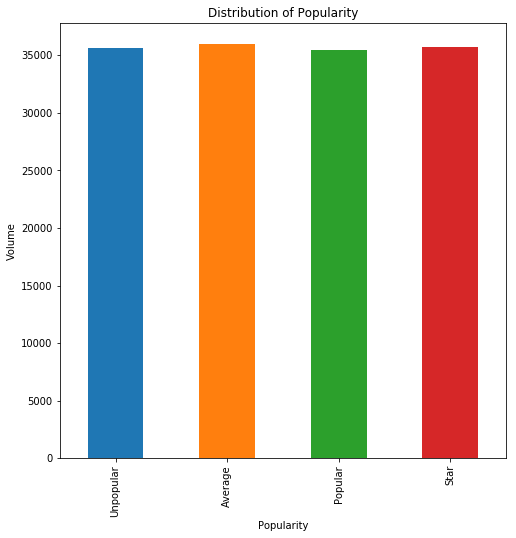

In [28]:
#ind = df_updated['Actor_Popularity'].value_counts().index
ind = ['Unpopular', 'Average', 'Popular', 'Star']
df_updated['Actor_Popularity'].value_counts()[ind].plot(kind='bar', figsize=(8, 8))
plt.title("Distribution of Popularity")
plt.xlabel("Popularity")
plt.ylabel("Volume");


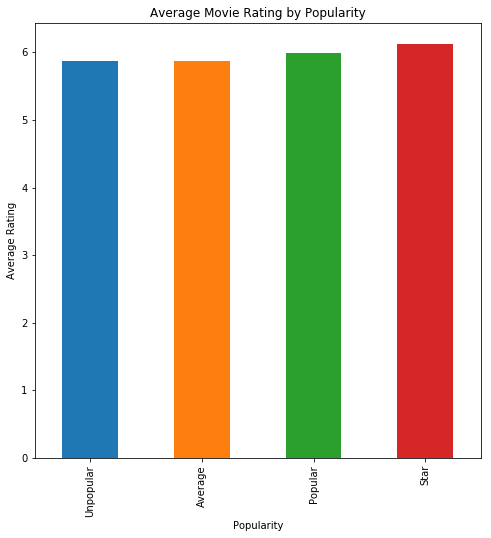

In [29]:
df_updated.groupby('Actor_Popularity')['vote_average'].agg('mean')[ind].plot(kind='bar', figsize=(8, 8))
plt.title("Average Movie Rating by Popularity")
plt.xlabel("Popularity")
plt.ylabel("Average Rating");

# We can see that actor popularity has very little impact on voter rating above

# How does actor popularity impact revenue?  When excluding movies without revenue in our filter, we can see below, the popularity of the actor does seem to be positively correlated with movie revenue

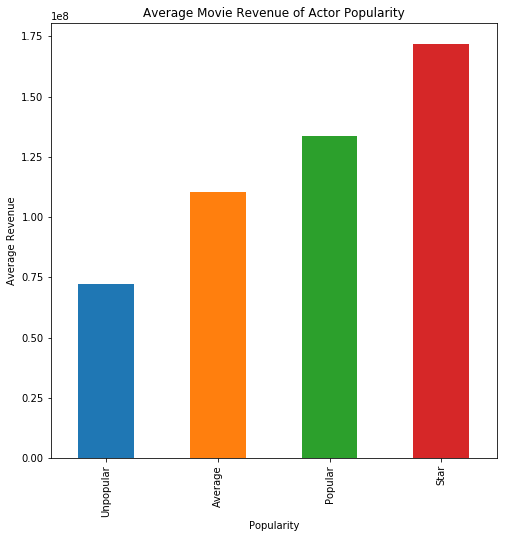

In [31]:
df_updated[df_updated['revenue_adj']>0].groupby('Actor_Popularity')['revenue_adj'].agg('mean')[ind].plot(kind='bar', figsize=(8, 8))

plt.title("Average Movie Revenue of Actor Popularity")
plt.xlabel("Popularity")
plt.ylabel("Average Revenue");

# What is the distribution of genres?  Do certain genres occur more frequently in the movie database? (1-D)

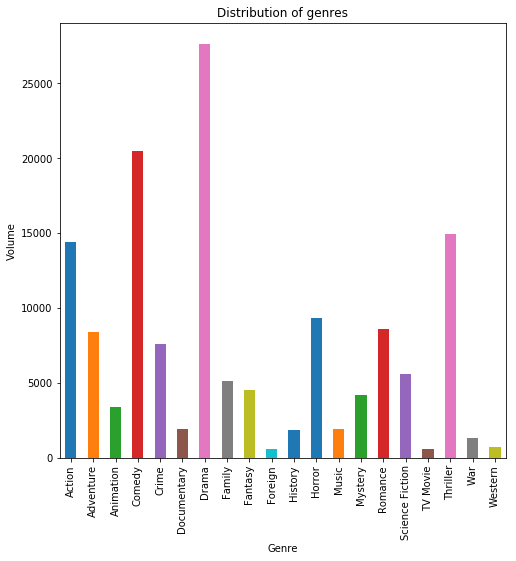

In [32]:
ind2 = df_updated['genres'].value_counts().index.sort_values()
df_updated['genres'].value_counts()[ind2].plot(kind='bar', figsize=(8, 8))
plt.title("Distribution of genres")
plt.xlabel("Genre")
plt.ylabel("Volume");


# Drama is by far the most popular genre, followed by comedy, thriller and action

# How does the genre impact the rating?  We can't seem to see a clear impact below

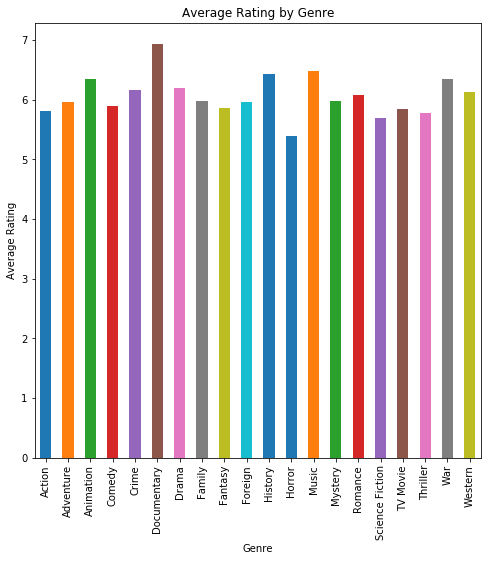

In [34]:
df_updated.groupby('genres')['vote_average'].agg('mean')[ind2].plot(kind='bar', figsize=(8, 8))
plt.title("Average Rating by Genre")
plt.xlabel("Genre")
plt.ylabel("Average Rating");

# Does runtime have an impact on rating?  Interestingly, we do see a slight improvement of rating as movie length increases, though we don't know if this is statistically significant.  The scatter plot doesn't show clear trends

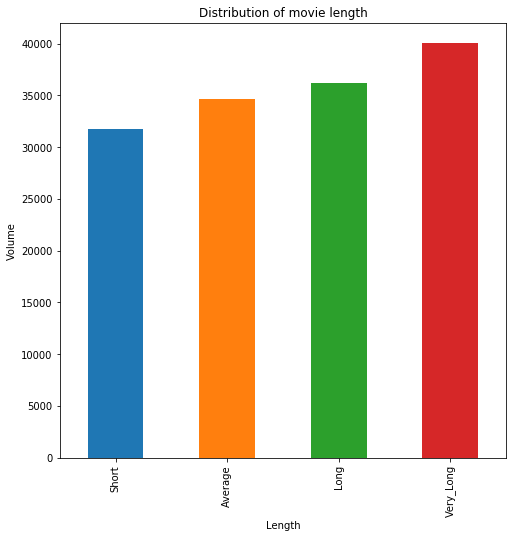

In [35]:
ind3 = ['Short', 'Average', 'Long', 'Very_Long']
df_updated['Movie_Length'].value_counts()[ind3].plot(kind='bar', figsize=(8, 8))
plt.title("Distribution of movie length")
plt.xlabel("Length")
plt.ylabel("Volume");


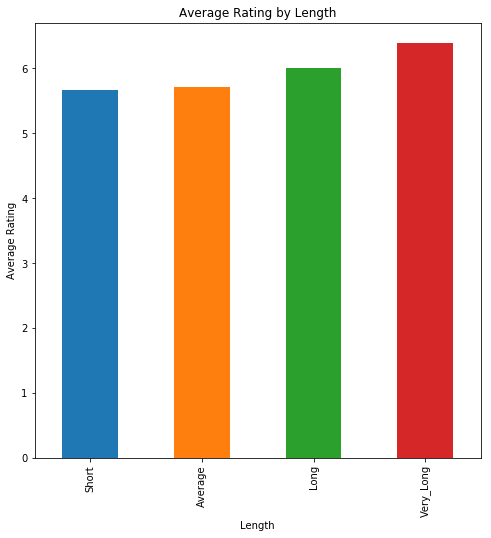

In [36]:
df_updated.groupby('Movie_Length')['vote_average'].agg('mean')[ind3].plot(kind='bar', figsize=(8, 8))
plt.title("Average Rating by Length")
plt.xlabel("Length")
plt.ylabel("Average Rating");

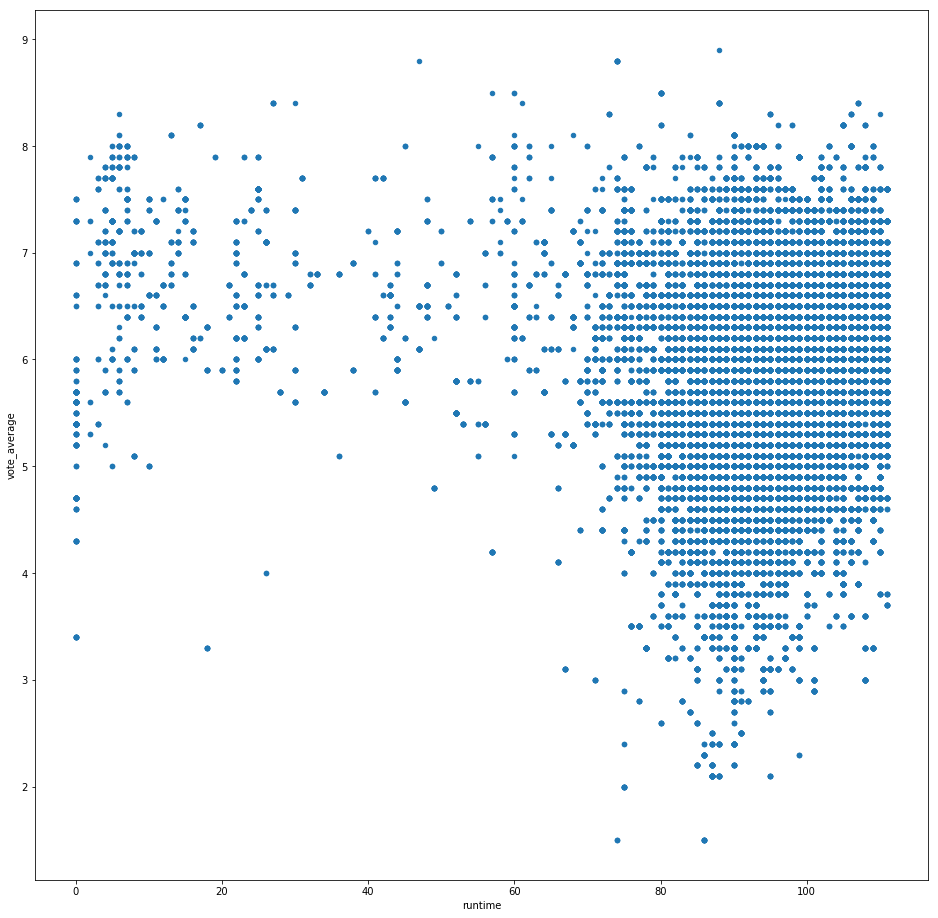

In [37]:
df_updated[df_updated['Movie_Length'] != 'Very_Long'].plot(x='runtime', y='vote_average', kind='scatter', figsize=(16,16));

# Does movie length have an impact on revenue?  You'll notice that non-revenue generating movies are excluded below.  Interestingly, movie length seems to have an impact on revenue

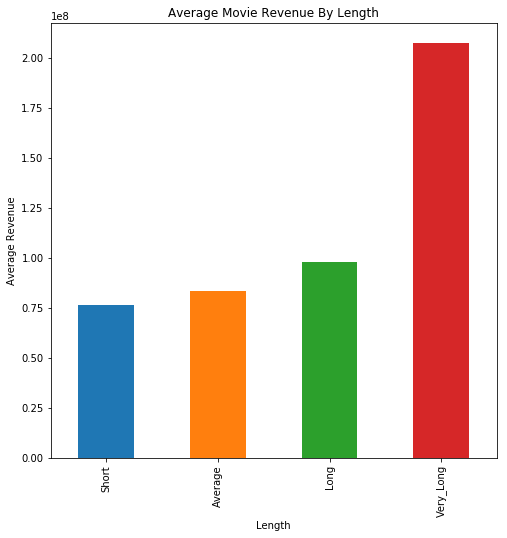

In [39]:
df_updated[df_updated['revenue_adj']>0].groupby('Movie_Length')['revenue_adj'].agg('mean')[ind3].plot(kind='bar', figsize=(8, 8))

plt.title("Average Movie Revenue By Length")
plt.xlabel("Length")
plt.ylabel("Average Revenue");

### Do higher budgets have higher movie ratings?  Please note the bins selected below don't include nan, thus the movies with no budget are not included in the chart below. It doesn't seem so, see below (note the first graph is just the distribution, the second graph is the 2-d graph that the statement is based on

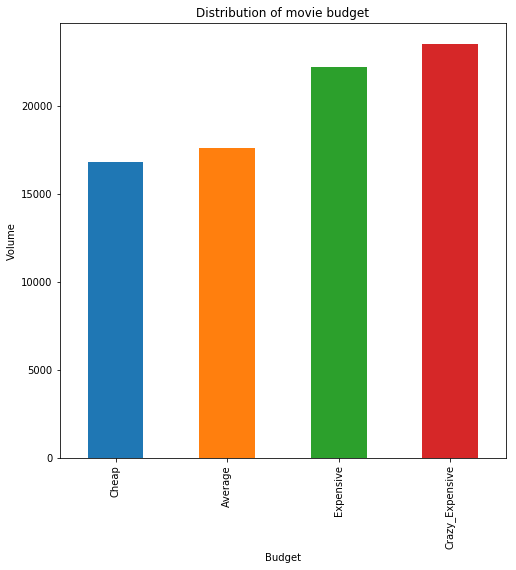

In [43]:
ind4 = ['Cheap', 'Average', 'Expensive', 'Crazy_Expensive']
df_updated['budget_bucket'].value_counts()[ind4].plot(kind='bar', figsize=(8, 8))
plt.title("Distribution of movie budget")
plt.xlabel("Budget")
plt.ylabel("Volume");

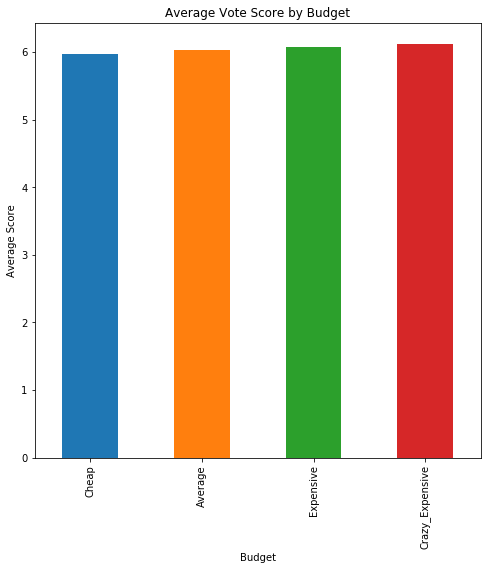

In [44]:
df_updated.groupby('budget_bucket')['vote_average'].agg('mean')[ind4].plot(kind='bar', figsize=(8, 8))

plt.title("Average Vote Score by Budget")
plt.xlabel("Budget")
plt.ylabel("Average Score");

# Do higher budgets generate more revenue?  It seems so (please note the indices used exclude nan, thus this is only including values that have revenue >0)

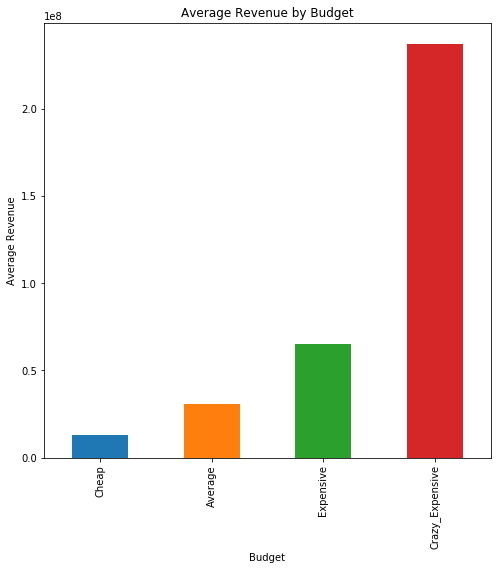

In [45]:
df_updated.groupby('budget_bucket')['revenue'].agg('mean')[ind4].plot(kind='bar', figsize=(8, 8))

plt.title("Average Revenue by Budget")
plt.xlabel("Budget")
plt.ylabel("Average Revenue");

# How is the distribution of release dates look like in this dataset?  We can see that significantly more movies after 2000 make up the dataset rather than before, despite having the release years go all the way back to 1960

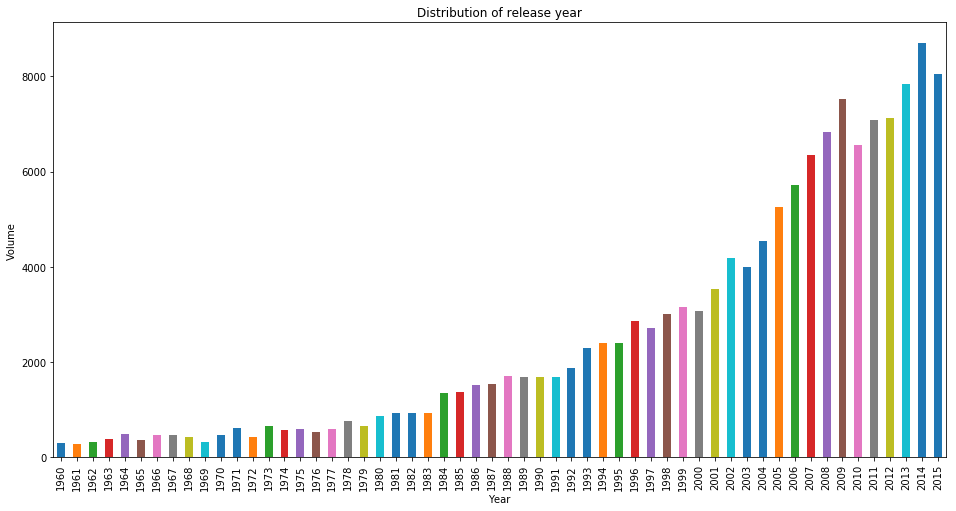

In [48]:
ind11 = df_updated['release_year'].value_counts().index.sort_values()
df_updated['release_year'].value_counts()[ind11].plot(kind='bar', figsize=(16, 8))
plt.title("Distribution of release year")
plt.xlabel("Year")
plt.ylabel("Volume");

# How has average rating trended over time?

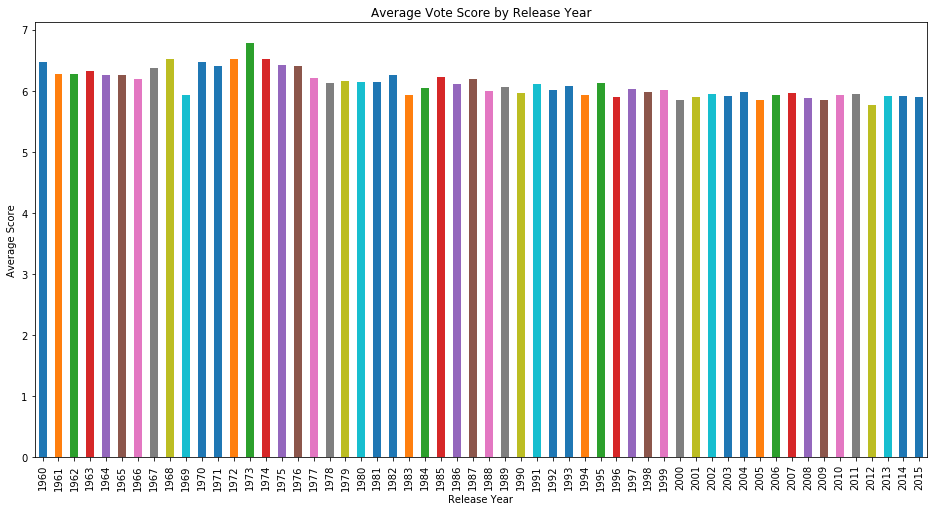

In [51]:
df_updated.groupby('release_year')['vote_average'].agg('mean')[ind11].plot(kind='bar', figsize=(16, 8))

plt.title("Average Vote Score by Release Year")
plt.xlabel("Release Year")
plt.ylabel("Average Score");

# There does seem to be a slight degrade in rating over time

<a id='conclusions'></a>
## Conclusions


### Based on my preliminary charts, I do not see strong evidence that actor popularity impacts movie rating, however, based on my preliminary bar charts, I do see that revenue tends to be higher with high profile actors.  I did not observe any correlation between genres and movie rating or movie revenue.  Regarding movie length, while I do see higher average ratings for longer movies, I don't have any insight into the statistical signficance of this.  Furthermore, looking at a scatter plot, I do not see a clear pattern.  I also see evidence that long movies generate more revenue, but it would be good to see if this is statistically significant.  We did have some limitations, the largest seemed to be missing significant revenue and budget data.  It would be interesting to see if our revenue analysis would be impacted with more data.  Furthremore, recent years over represent our data.  It would be interesting to see how much our analysis would change with each year being equally represented in the data.  For example, rating might be impacted over time.